# National tourism promotion:

# Data Preparation

- In this next part, we are going to proceed to resolve the issues detected in the Data Understanding phase.
- Important note: Please check the UserLocCleaning Notebook, as it provides the code used to normalize the User Location Column. Since this was a time-consuming procedure, we decided to do it in a separate notebook to avoid having to run the code multiple times.

### 1. Initial Setup: packages loading

In [ ]:
#pip install googletrans==4.0.0-rc1
#pip install pycountry
#pip install langid
#pip install langdetect
#pip install --upgrade httpcore
#pip install --upgrade googletrans==4.0.0-rc1
#pip install --upgrade googletrans
#pip install mtranslate
#pip install --upgrade httpcore

In [1]:
# Packages
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import joypy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx
from math import ceil
from datetime import datetime
import pycountry
import time
from translate import Translator
from langdetect import detect
import langid
from googletrans import Translator
from mtranslate import translate
import re
import html

C:\Users\catar\anaconda3\Lib\site-packages\httpx\_models.py:1: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


### 2. Functions

In [2]:
def translate_to_english(holiday_name):
    try:
        translator= Translator(to_lang="en")
        translation = translator.translate(holiday_name)
        time.sleep(1)  # Adding a delay to avoid potential blocking
        return translation
    except Exception as e:
        print(f"Translation error: {e}")
        print(f"Holiday name: {holiday_name}")
        return holiday_name  # Return the original text on error

In [3]:
def translate_to_english(text):
    translation = translate(text, 'en')
    return translation

### 3. Data importation and Exploration

Dataframe with the first sheet of the EuropeTop100 excel 

In [4]:
#dataframe with the first sheet of the europwTop100 excel 
df1 = pd.read_excel('EuropeTop100Attractions_ENG_20190101_20210821.xlsx')

In [5]:
df1.shape

(92120, 15)

dataframe with the second sheet - Attractions

In [6]:
Attractions = pd.read_excel('EuropeTop100Attractions_ENG_20190101_20210821.xlsx', sheet_name='Attractions')

In [7]:
Attractions.shape

(100, 4)

We noticed that merging these two data frames was causing us to lose lines because we used "localId" to perform the merge. As we observed in the Data Understanding phase, two IDs (u and genis) are not in the correct format, and as a result, they are not recognized during the merge. - we need to correct this before the merge

Importing the clean unique user locations 

In [8]:
clean_user_location = pd.read_excel("UserLocationClean.xlsx", sheet_name='IsoCodes', engine="openpyxl")

In [9]:
clean_user_location.shape

(12613, 2)

In [10]:
clean_user_location.head()

,userLocation,userISOCode
0,"Indianapolis, IN",US
1,"Bandon, Ireland",IE
2,"Valencia, Spain",ES
3,"Madrid, Spain",ES
4,"Towaco, NJ",US


### 4. Data Cleaning
#### 4.1. Data cleaning of sheet Attractions

Quality Assessment from Data understanding: 
- Scot (line 62) need to be corrected to Scotland
- Line 44 - Poland - HR - wrong ISO code
- Curaçao is not in Europe
- Line 77 - Italy - VA; it's best to consider Vatican City with Italy ISO code.

In [11]:
Attractions.head()

,ID,Name,Country,ISO
0,MAG001,Basilica of the Sagrada Familia,Spain,ES
1,MAG002,Parc Guell,Spain,ES
2,MAG003,Tower of London,England,UK
3,MAG004,Casa Batllo,Spain,ES
4,MAG005,Staromestske namesti,Czech Republic,CZ


In [12]:
Attractions[Attractions.duplicated(subset='ID', keep=False)]

,ID,Name,Country,ISO


##### All the Ids are unique, and as we´ve seen before we have 2 attractions with the same name but they are in different countries:

##### All the Ids are unique, lets see if we have the different Ids for the same attraction:

In [13]:
Attractions[Attractions.duplicated(subset='Name', keep=False)]

,ID,Name,Country,ISO
30,MAG031,Old Town,Croatia,HR
44,MAG045,Old Town,Poland,HR


##### So we have 2 attarattions with the same name but they are in different countries so they need different Ids.

In [14]:
Attractions.drop_duplicates(subset=['Country','ISO'])[['Country','ISO']].sort_values(by='Country')

,Country,ISO
6,Austria,AT
12,Belgium,BE
59,Bulgaria,BG
30,Croatia,HR
82,Curaçao,NL
75,Cyprus,CY
4,Czech Republic,CZ
2,England,UK
39,Estonia,EE
69,Finland,FI


In [15]:
Attractions['Country'].replace({'Scot': 'Scotland'}, inplace=True)

In [16]:
Attractions['ISO'] = Attractions['ISO'].mask((Attractions['ISO'] == 'HR') & (Attractions['Country'] == 'Poland'), 'PL')

In [17]:
Attractions['ISO'].replace({'VA': 'IT'}, inplace=True)

In [18]:
Attractions['ISO'].replace({'UK': 'GB'}, inplace=True)

We need to eliminate the reviews from Curaçao, but we are planning to do this after the merge to ensure that the rows are consistent first.

In [19]:
Attractions[Attractions['Country'] == 'Curaçao']

,ID,Name,Country,ISO
82,MAG083,Queen Emma Pontoon Bridge,Curaçao,NL


In [20]:
Attractions.shape

(100, 4)

#### 4.2. Sheet Reviews
Quality Assessment from Data understanding: 

- **`userLocation`** column is a good column to explore but since the data format is not normalize (has various types like NY, New York or United States...), we need to normalize this column to analyze potencial patterns.

- **Missing Values:** Four columns have missing values: `userName`, `userLocation`, `tripType`, and `reviewVisited`. Addressing this issue will be a priority during the Data Preparation section.

- **Outliers:** The dataset exhibits outliers in terms of `usercontributions` and `totalReviews`, with a significantly deviating from the mean. This will require further investigation.

- **Duplicate Rows:** There are 7,012 potential duplicate rows (excluding `extractionDate`). These entries will undergo further analysis to determine their nature and relevance.

- `LocalID` values with 'u' and 'genis' need to be replaced.

In [21]:
df1.describe(include='all', datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
localID,92120,100,MAG001,8309,NaN,NaN,NaN,NaN,NaN,NaN,NaN
extractionDate,92120,NaN,NaN,NaN,2021-08-20 22:09:20.598932992,2021-08-20 08:24:40.077000,2021-08-20 12:08:10.831000064,2021-08-20 15:46:58.171000064,2021-08-21 12:35:39.817250048,2021-08-21 16:27:17.026000,NaN
globalRating,92120.0,NaN,NaN,NaN,4.485166,4.0,4.5,4.5,4.5,5.0,0.178085
positionOnRanking,92120.0,NaN,NaN,NaN,3.91459,1.0,1.0,2.0,6.0,55.0,4.843013
sitesOnRanking,92120.0,NaN,NaN,NaN,748.263537,5.0,154.0,484.0,1186.0,3837.0,802.742304
totalReviews,92120.0,NaN,NaN,NaN,40556.601813,5179.0,14152.0,24454.0,51324.0,163828.0,42914.381014
userName,92100,65785,Malgorzata@Margo7850p,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userLocation,78652,12613,"London, UK",3710,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userContributions,92120.0,NaN,NaN,NaN,477.52056,0.0,20.0,66.0,215.0,607732.0,7270.518677
tripType,63052,5,Couples,31702,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### userLocation with 12613 values, the exact same as the 'clean_user_location' dataframe as expected

### - 'userLocation' preparation
We have the dataframe with the unique values, and we are now going to perform the merge and address potential issues.

In [22]:
reviews = pd.merge(df1, clean_user_location, on='userLocation', how='left')

In [23]:
reviews.head(1)

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText,userISOCode
0,MAG001,2021-08-20 08:24:40.077,4.5,1,1186,163828,Maurice M@MauriceM171,"Indianapolis, IN",29,Couples,2021-08-18,2021-08-01,5,en,"Absolutely breathtaking use of light, an amazi...",US


In [24]:
reviews.shape

(92120, 16)

In [25]:
# Fill NaN values in 'userISOCode' column with None where 'userLocation' is NaN
reviews['userISOCode'] = reviews.apply(lambda row: None if pd.isna(row['userLocation']) else row['userISOCode'], axis=1)

In [26]:
reviews.head(4)

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText,userISOCode
0,MAG001,2021-08-20 08:24:40.077,4.5,1,1186,163828,Maurice M@MauriceM171,"Indianapolis, IN",29,Couples,2021-08-18,2021-08-01,5,en,"Absolutely breathtaking use of light, an amazi...",US
1,MAG001,2021-08-20 08:24:40.097,4.5,1,1186,163828,nickchamb@nickchamb,"Bandon, Ireland",7,Couples,2021-08-17,2021-03-01,5,en,A really interesting and beautiful place to vi...,IE
2,MAG001,2021-08-20 08:24:40.117,4.5,1,1186,163828,Arthur Villon@arthur4588,"Valencia, Spain",268,Friends,2021-08-16,2021-08-01,5,en,Beautiful place and must visit place in barcel...,ES
3,MAG001,2021-08-20 08:24:40.147,4.5,1,1186,163828,James U@696jamesu,NaN,7,NaN,2021-08-16,2021-07-01,5,en,A MUST when visiting Barcelkona. It is consta...,None


In [27]:
# Count rows where 'userLocation' is not NaN, but 'userISOCode' is NaN
count_info_and_nan = (reviews['userLocation'].notna() & reviews['userISOCode'].isna()).sum()

print(f"Number of rows with information in 'userLocation' and NaN in 'userISOCode': {count_info_and_nan}")

Number of rows with information in 'userLocation' and NaN in 'userISOCode': 14


In [28]:
print(reviews.loc[reviews['userLocation'].notna() & reviews['userISOCode'].isna(), ['userLocation', 'userISOCode']])

                 userLocation userISOCode
5284   Katima Mulilo, Namibia         NaN
7918      Walvis Bay, Namibia         NaN
8060        Windhoek, Namibia         NaN
10069  Katima Mulilo, Namibia         NaN
11016     Walvis Bay, Namibia         NaN
11026     Walvis Bay, Namibia         NaN
13460       Windhoek, Namibia         NaN
17921  Katima Mulilo, Namibia         NaN
18437       Windhoek, Namibia         NaN
49573       Windhoek, Namibia         NaN
58264     Walvis Bay, Namibia         NaN
77283     Walvis Bay, Namibia         NaN
81757     Walvis Bay, Namibia         NaN
90565     Walvis Bay, Namibia         NaN


##### namibia tem iso code 'NA' por isso esta a ficar NaN

In [29]:
locations_to_correct = ['Katima Mulilo, Namibia', 'Walvis Bay, Namibia', 'Windhoek, Namibia']
reviews.loc[reviews['userLocation'].isin(locations_to_correct), 'userISOCode'] = 'NA'

In [30]:
count_info_and_nan = (reviews['userLocation'].notna() & reviews['userISOCode'].isna()).sum()
print(f"Number of rows with information in 'userLocation' and NaN in 'userISOCode': {count_info_and_nan}")

Number of rows with information in 'userLocation' and NaN in 'userISOCode': 0


### - 'reviewWritten' &	'reviewVisited' cleaning

In [31]:
# Conversion of date columns to datetime, turning parsing errors into NaT
reviews['reviewWritten'] = pd.to_datetime(reviews['reviewWritten'], errors='coerce')
reviews['reviewVisited'] = pd.to_datetime(reviews['reviewVisited'], errors='coerce')
reviews['extractionDate'] = pd.to_datetime(reviews['extractionDate'], errors='coerce')

In [32]:
# Replace dates after extraction date with extraction date
reviews['reviewWritten'] = np.where(reviews['reviewWritten'] > reviews['extractionDate'], reviews['extractionDate'], reviews['reviewWritten'])
reviews['reviewVisited'] = np.where(reviews['reviewVisited'] > reviews['extractionDate'], reviews['extractionDate'], reviews['reviewVisited'])

In [33]:
# Check if any date in 'reviewVisited' is after 'reviewWritten'
dates_switch = reviews['reviewVisited'] > reviews['reviewWritten']
dates_switch.sum()

22

In [34]:
reviews.loc[reviews['reviewVisited'] > reviews['reviewWritten'], 'reviewVisited'] = reviews['reviewWritten']

In [35]:
dates_switch = reviews['reviewVisited'] > reviews['reviewWritten']
dates_switch.sum()

0

In [36]:
# Fill NaN values in 'reviewVisited' with corresponding values from 'reviewWritten'
reviews['reviewVisited'].fillna(reviews['reviewWritten'], inplace=True)

### - Remove Columns with no useful information

In [37]:
reviews.drop(['extractionDate', 'reviewLanguage', 'sitesOnRanking'], axis=1, inplace=True)

In [38]:
reviews.head()

,localID,globalRating,positionOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewFullText,userISOCode
0,MAG001,4.5,1,163828,Maurice M@MauriceM171,"Indianapolis, IN",29,Couples,2021-08-18,2021-08-01,5,"Absolutely breathtaking use of light, an amazi...",US
1,MAG001,4.5,1,163828,nickchamb@nickchamb,"Bandon, Ireland",7,Couples,2021-08-17,2021-03-01,5,A really interesting and beautiful place to vi...,IE
2,MAG001,4.5,1,163828,Arthur Villon@arthur4588,"Valencia, Spain",268,Friends,2021-08-16,2021-08-01,5,Beautiful place and must visit place in barcel...,ES
3,MAG001,4.5,1,163828,James U@696jamesu,NaN,7,NaN,2021-08-16,2021-07-01,5,A MUST when visiting Barcelkona. It is consta...,None
4,MAG001,4.5,1,163828,Kamal K Sirra@Sirra63,"Madrid, Spain",516,Family,2021-08-15,2021-07-01,4,I visited about 20 years ago and there has bee...,ES


### - reviewFullText cleaning

We observed that the 'reviewFullText' column has 92,120 entries, but only 85,088 are unique. This difference could be from System glitches during data submission that could lead to duplicate entries, problems during data extraction process, or even Review Edits  captured during extraction. To investigate, we plan to check if these repetitions match the same user and ID. Identifying cases where entries share the same 'reviewFullText,' user, and ID will help understand if these are edited reviews.

In [39]:
duplicates_excluding_column = reviews[reviews.duplicated()]
duplicates_excluding_column.shape[0]

7012

We are going to exclude the reviewWritten from this subsetting because if the same user wrote the same review text for the same attraction, which is visited on the same day, then the review duplicate could be an edited review (the user might have edited the reviewRating, the trip type, etc.). Therefore, we are going to assume that the most recent review is the correct one.

In [40]:
duplicates_excluding_columns = reviews[reviews.duplicated(subset=['userName', 'reviewFullText', 'localID', 'reviewVisited'])]
duplicates_excluding_columns.shape[0]

7018

In [41]:
reviews[reviews.duplicated(subset=['userName', 'reviewFullText', 'localID', 'reviewVisited'], keep=False)].sort_values(by=['reviewFullText']).head(2)

,localID,globalRating,positionOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewFullText,userISOCode
57356,MAG030,4.5,2,18474,GlobeTrotting828238@GlobeTrotting828238,NaN,4,NaN,2019-09-08,2019-08-01,5,able to attend a concert the flamenco dance...,None
57346,MAG030,4.5,2,18474,GlobeTrotting828238@GlobeTrotting828238,NaN,4,NaN,2019-09-08,2019-08-01,5,able to attend a concert the flamenco dance...,None


In [42]:
reviews['reviewWritten'] = pd.to_datetime(reviews['reviewWritten'], errors='coerce')
reviews = reviews.sort_values(by=['userName', 'reviewWritten'], ascending=[True, False])
reviews.drop_duplicates(subset=['userName', 'reviewFullText', 'localID', 'reviewVisited'], keep='first', inplace=True)
reviews.reset_index(drop=True, inplace=True)

Also, we notice that when the text reviews are too long and pass to another line so we need to agg the rows:

In [43]:
reviews.duplicated(subset=['userName', 'reviewRating', 'localID', 'reviewVisited']).sum()

193

In [44]:
reviews[reviews.duplicated(subset=['userName', 'reviewRating', 'localID', 'reviewVisited'], keep=False)].sort_values(by=['userName']).head(2)

,localID,globalRating,positionOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewFullText,userISOCode
398,MAG069,4.5,2,8582,21cyndyc@21cyndyc,"Holyhead, UK",263,NaN,2019-06-10,2019-06-01,5,So breathtakingly beautiful whatever time of t...,GB
399,MAG069,4.5,2,8582,21cyndyc@21cyndyc,"Holyhead, UK",263,Friends,2019-06-10,2019-06-01,5,Kew is beyond description. Any time of year is...,GB


In [45]:
# Create a merge column
reviews['merge_column'] = (
    reviews['userName'].astype(str) +
    reviews['reviewRating'].astype(str) +
    reviews['localID'].astype(str) +
    reviews['reviewVisited'].astype(str)
)

# Aggregate based on the merge column and concatenate 'reviewFullText'
reviews_aggregated = reviews.groupby('merge_column', as_index=False).agg({
    'tripType': 'last',
    'userLocation': 'last',
    'userISOCode': 'last',
    'reviewWritten': 'max',  # Keeping the most recent date
    'reviewFullText': lambda x: ' '.join(map(str, x))  # Convert values to strings before joining
})

# Merge the aggregated values back into the original DataFrame
reviews = pd.merge(reviews, reviews_aggregated, on='merge_column', how='left', suffixes=('', '_agg'))

# Keep the non-NaN values or the last value if both are NaN
reviews['tripType'] = reviews.apply(lambda row: row['tripType_agg'] if pd.notna(row['tripType_agg']) else row['tripType'], axis=1)
reviews['userLocation'] = reviews.apply(lambda row: row['userLocation_agg'] if pd.notna(row['userLocation_agg']) else row['userLocation'], axis=1)
reviews['userISOCode'] = reviews.apply(lambda row: row['userISOCode_agg'] if pd.notna(row['userISOCode_agg']) else row['userISOCode'], axis=1)

reviews = reviews.drop(['merge_column', 'tripType_agg', 'userLocation_agg', 'userISOCode_agg', 'reviewWritten_agg'], axis=1)
reviews.reset_index(drop=True, inplace=True)

We are presenting data for the same user to illustrate a noteworthy observation. Firstly, the reviewFullText_agg field now consolidates the content from both reviews. Secondly, to mitigate the risk of data loss in other columns – exemplified in this user's case where one review specifies the tripType and the other does not – a approach is employed. The methodology ensures that during aggregation, if a column contains information, it takes precedence, thereby preserving valuable data and preventing unintended loss in scenarios where individual reviews contribute distinct details to shared columns.

In [46]:
pd.set_option('display.max_colwidth', None)  
reviews.loc[(reviews['userName'] == '21cyndyc@21cyndyc') & (reviews['localID'] == 'MAG069'), ['reviewFullText', 'reviewFullText_agg', 'userName', 'localID', 'tripType']]

,reviewFullText,reviewFullText_agg,userName,localID,tripType
398,So breathtakingly beautiful whatever time of the year you visit. Especially great just now because of all the wonderful glass sculptures dotted around the gardens at present.,"So breathtakingly beautiful whatever time of the year you visit. Especially great just now because of all the wonderful glass sculptures dotted around the gardens at present. Kew is beyond description. Any time of year is the best time. As it was a little wet we took the train around some of the gardens. Oh boy, it's breath taking. The trees are a true wonder, as are the floral displays. The glass houses are indescribable in words that do them any justice. Add an extra treat to the day and return to the city on a boat on the Thames!",21cyndyc@21cyndyc,MAG069,Friends
399,"Kew is beyond description. Any time of year is the best time. As it was a little wet we took the train around some of the gardens. Oh boy, it's breath taking. The trees are a true wonder, as are the floral displays. The glass houses are indescribable in words that do them any justice. Add an extra treat to the day and return to the city on a boat on the Thames!","So breathtakingly beautiful whatever time of the year you visit. Especially great just now because of all the wonderful glass sculptures dotted around the gardens at present. Kew is beyond description. Any time of year is the best time. As it was a little wet we took the train around some of the gardens. Oh boy, it's breath taking. The trees are a true wonder, as are the floral displays. The glass houses are indescribable in words that do them any justice. Add an extra treat to the day and return to the city on a boat on the Thames!",21cyndyc@21cyndyc,MAG069,Friends


In [47]:
pd.reset_option('display.max_colwidth') 

In [48]:
reviews[(reviews['reviewWritten'].isnull()) | (reviews['reviewFullText_agg'].isnull())]

,localID,globalRating,positionOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewFullText,userISOCode,reviewFullText_agg


In [49]:
reviews['reviewWritten'] = pd.to_datetime(reviews['reviewWritten'], errors='coerce')
reviews = reviews.sort_values(by=['userName', 'reviewWritten'], ascending=[True, False])

# Drop duplicates based on specified columns and keep the row with the most recent 'reviewWritten'
reviews.drop_duplicates(subset=['userName', 'reviewFullText_agg', 'localID', 'reviewVisited', 'reviewRating'], inplace=True)
reviews.reset_index(drop=True, inplace=True)

In [50]:
reviews.drop('reviewFullText', axis=1, inplace=True)

In [51]:
reviews.loc[(reviews['userName'] == '21cyndyc@21cyndyc') & (reviews['localID'] == 'MAG069')]

,localID,globalRating,positionOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,userISOCode,reviewFullText_agg
398,MAG069,4.5,2,8582,21cyndyc@21cyndyc,"Holyhead, UK",263,Friends,2019-06-10,2019-06-01,5,GB,So breathtakingly beautiful whatever time of t...


In [52]:
reviews.shape

(84909, 13)

 92 120 - 7018 - 193 = 84 909

In [53]:
duplicates_excluding_column = reviews[reviews.duplicated()]
duplicates_excluding_column.shape[0]

0

In [54]:
reviews[reviews.duplicated(subset=['reviewFullText_agg'], keep=False)].sort_values(by=['reviewFullText_agg']).head(4)

,localID,globalRating,positionOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,userISOCode,reviewFullText_agg
80732,MAG048,4.5,1,12696,ruthboldes@ruthboldes,"Mevaseret Zion, Israel",10,Couples,2019-09-14,2019-09-01,5,IL,A must-see place for any traveler in St. Peter...
80730,MAG016,4.5,3,26604,ruthboldes@ruthboldes,"Mevaseret Zion, Israel",10,Couples,2019-09-14,2019-09-01,5,IL,A must-see place for any traveler in St. Peter...
80731,MAG027,5.0,1,21630,ruthboldes@ruthboldes,"Mevaseret Zion, Israel",10,Couples,2019-09-14,2019-09-01,5,IL,A must-see place for any traveler in St. Peter...
8444,MAG002,4.0,11,75909,Bluebonet@Bluebonet,"Houston, TX",176,Couples,2019-06-23,2019-05-01,5,US,Amazing Architecture that is best described as...


##### We have identified some remaining duplicates in the 'reviewFullText' column, which may arise from different users or the same user describing multiple attractions using the same text. This situation is expected, as users might provide similar reviews for different places or even copy text from others. However, these duplicates can still offer insights into user sentiments and experiences, it doesn't necessarily impede the usability of the reviews. - for example first 2 lines is all the same except for the local ID

### - Outliers

- `sitesOnRanking`: The total number of attractions in TripAdvisor's regional ranking at the extraction date can change due to the time needed to make the extraction.

Decision: Not critical for analysis, and fluctuations are expected due to extraction time. No need to treat outliers.

- `totalReviews` - Sagrada Familia (MAG001) represents the monument with the most reviews as of the extraction date. This outlier may indicate a significant level of interest or popularity for this particular attraction, suggesting a potential pattern in user engagement. 

Decision: Indicates significant interest or popularity. Valuable for further analysis, and therefore, should be maintained. BUT Despite its significance for further analysis, it's acknowledged that the substantial number of visits to Sagrada Familia might dominate and influence overall trends. To address this outlier, special models will be created when necessary, ensuring a focused examination of this distinct monument's impact.

- `userContributions`: Some users have a  substantial amount of contributions comparing to the mean. P.E. The user 'Neil K@293neilk' has more than 600 000 contributions, which is quite substantial considering that the majority of users around 500.

Decision: Our Goal is to understand typical user behavior. We notice that some users have a incredible amount of reviews but not all are in Europe - bias introduced by a user who may primarily rate attractions in the US for example. So we decided that:   
- We are going to treat these outliers by giving it the MAX value from the ”valid” maximum values - since this is the total reviews from the user (not only to europe attarctions) this is not a significant change and we can still consider this user in the range of frequent contributors. - we just need to have this in mind in our analysis. 

In [55]:
extreme_upper_bound = reviews['userContributions'].quantile(0.75) + 3 * (reviews['userContributions'].quantile(0.75) - reviews['userContributions'].quantile(0.25))
extreme_upper_bound

800.0

In [56]:
users_above_1000 = reviews[reviews['userContributions'] > extreme_upper_bound]
num_unique_users_above_1000 = users_above_1000['userName'].nunique()

In [57]:
(num_unique_users_above_1000 / reviews['userName'].nunique()) * 100

4.374857490309341

In our analysis of the userContributions column, we deviated from the standard 1.5 multiplier in the interquartile range (IQR) due to the highly positively skewed distribution. Opting for a multiplier of 3, typically used for extreme outliers, was motivated by the desire to maintain a broader range for evaluating frequent contributors.

The impact analysis revealed that only 4% of users were affected by this choice, making the 3-multiplier reasonable. However, it's important to consider this when defining criteria for frequent contributors.
An alternative approach could have involved recalculating the userContributions column by considering the total reviews per user in our dataset. However, this option was dismissed in favor of maintaining the importance of extremely well-traveled users. These users, with potentially high userContributions, play a valuable role in the dataset, particularly as they start to appear more frequently in the European region.

In [58]:
# Replace outliers in the target column with the upper bound value
reviews['userContributions'] = reviews['userContributions'].apply(lambda x: extreme_upper_bound if x > extreme_upper_bound else x)

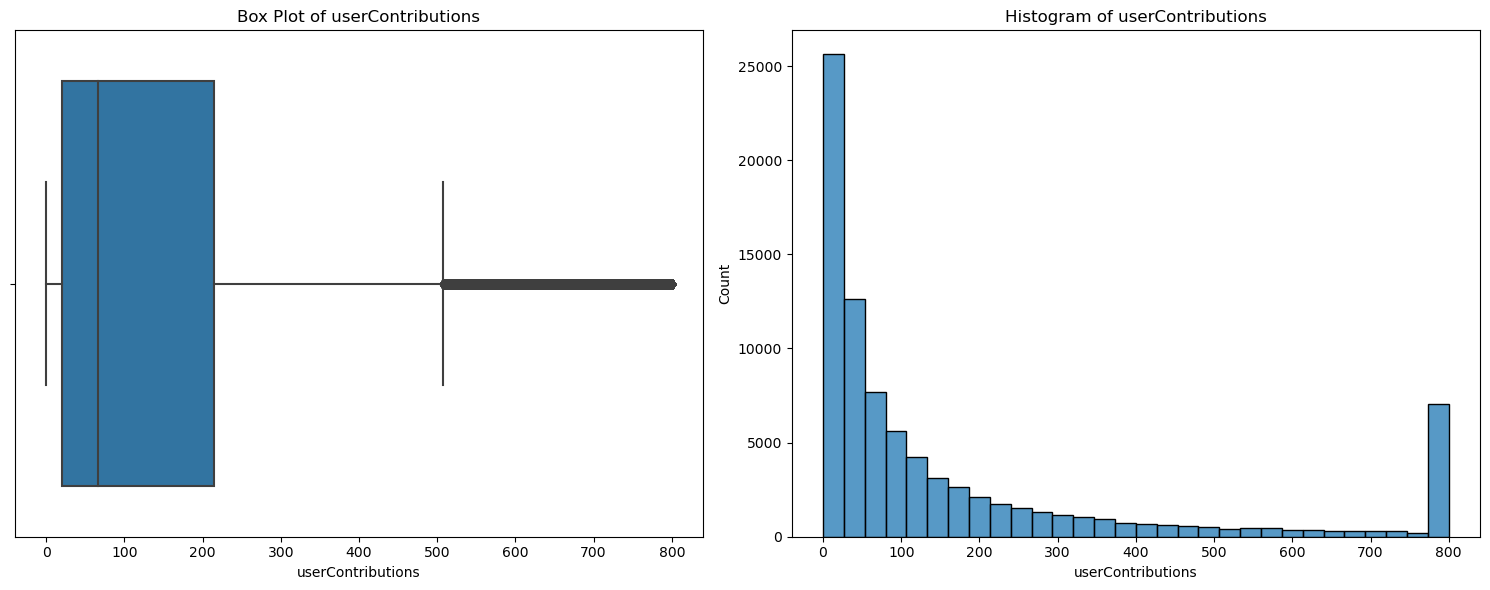

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Box plot
sns.boxplot(x=reviews['userContributions'], ax=axes[0])
axes[0].set_title('Box Plot of {}'.format('userContributions'))

# Histogram
sns.histplot(reviews['userContributions'], bins=30, ax=axes[1])
axes[1].set_title('Histogram of {}'.format('userContributions'))
axes[1].set_xlabel('userContributions')
plt.tight_layout()
plt.show()

Now, with a clearer view of the userContributions column values, we've successfully addressed the skewed distribution. While outliers persist, we can now identify these as our extreme frequent contributors. This approach allows us to better appreciate and define the contributions of users with exceptionally high values in the dataset.
Previously, the skewed distribution of the userContributions column made it challenging to discern the underlying pattern of values. However, with the adjustments made, we have successfully brought clarity to the distribution, enabling a more informed identification of extreme frequent contributors.

### - LocalID normalization to perform the merge using this column

In [60]:
invalid_localIDs = (reviews[~reviews['localID'].apply(lambda x: bool(re.match(r'^MAG\d{3}$', str(x))))]
                      ['localID']
                      .value_counts()
                      .reset_index()
                      .rename(columns={'index': 'localID', 'localID': 'Count'}))

print(invalid_localIDs)

  localID  Count
0       u   4699
1   genis    469


In [61]:
localID_replace = {'genis': 'MAG005', 'u': 'MAG006'}
reviews['localID'] = reviews['localID'].replace(localID_replace)

### 6. Merging reviews and attractions

In [62]:
#Merge the two dataframes in one, by local id
reviews_clean = pd.merge(reviews, Attractions, left_on='localID', right_on='ID')

In [63]:
#eliminar coluna repetida 
reviews_clean=reviews_clean.drop('ID',axis=1)  

In [64]:
#See dataframe
reviews_clean.head(5)

,localID,globalRating,positionOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,userISOCode,reviewFullText_agg,Name,Country,ISO
0,MAG013,4.5,1,34353,#1 Best@Number1Best,"Ruwais, United Arab Emirates",49.0,Friends,2019-01-11,2018-08-01,5,AE,"There’s not much “sightseeing” in Brussels, wh...",Grand Place,Belgium,BE
1,MAG013,4.5,1,34353,#travelswithhugodog@ajotraveller2016,"Leeds, UK",81.0,NaN,2019-11-03,2019-07-01,5,GB,Beautiful square - well lit and lots of food a...,Grand Place,Belgium,BE
2,MAG013,4.5,1,34353,--Isma-1010@--Isma-1010,"London, UK",10.0,Friends,2019-01-09,2019-01-01,5,GB,Definitely one of the most beautiful squares o...,Grand Place,Belgium,BE
3,MAG013,4.5,1,34353,164roxanne@164roxanne,"Dallas, TX",13.0,Solo,2019-06-27,2019-06-01,3,US,It's very grand and beautiful... and of course...,Grand Place,Belgium,BE
4,MAG013,4.5,1,34353,19Spenc53@19Spenc53,"London, UK",29.0,NaN,2020-03-04,2020-03-01,5,GB,You need to visit both during the day and at n...,Grand Place,Belgium,BE


In [65]:
reviews_clean.shape

(84909, 16)

##### We lost some rows bc we remove some duplicate reviews. 84 409 was the expected result (se reviews description after reviewfulltext cleaning)

#### Removing Curaçao

In [66]:
reviews_clean = reviews_clean[reviews_clean['localID'] != 'MAG083']

In [67]:
reviews_clean.describe(include='all', datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
localID,84518,99,MAG001,7901,NaN,NaN,NaN,NaN,NaN,NaN,NaN
globalRating,84518.0,NaN,NaN,NaN,4.48456,4.0,4.5,4.5,4.5,5.0,0.179127
positionOnRanking,84518.0,NaN,NaN,NaN,3.906162,1.0,1.0,2.0,6.0,55.0,4.849753
totalReviews,84518.0,NaN,NaN,NaN,41052.609089,5179.0,14354.0,24454.0,51324.0,163828.0,43470.585083
userName,84506,65429,Malgorzata@Margo7850p,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userLocation,72185,12541,"London, UK",3414,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userContributions,84518.0,NaN,NaN,NaN,175.763234,0.0,20.0,66.0,215.0,800.0,238.523678
tripType,57869,5,Couples,29130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewWritten,84518,NaN,NaN,NaN,2019-09-01 05:35:23.334674432,2019-01-01 00:00:00,2019-05-12 00:00:00,2019-08-07 00:00:00,2019-11-03 00:00:00,2021-08-21 00:00:00,NaN
reviewVisited,84518,NaN,NaN,NaN,2019-07-18 09:54:51.445609216,2015-10-01 00:00:00,2019-04-01 00:00:00,2019-07-01 00:00:00,2019-10-01 00:00:00,2021-08-20 00:00:00,NaN


In [68]:
reviews_clean.shape

(84518, 16)

#### - Missing values 

In [69]:
reviews_clean.isnull().sum()

localID                   0
globalRating              0
positionOnRanking         0
totalReviews              0
userName                 12
userLocation          12333
userContributions         0
tripType              26649
reviewWritten             0
reviewVisited             0
reviewRating              0
userISOCode           12333
reviewFullText_agg        0
Name                      0
Country                   0
ISO                       0
dtype: int64

In [70]:
constant_value = "NULL"
reviews_clean['userLocation'].fillna(constant_value, inplace=True)
reviews_clean['tripType'].fillna(constant_value, inplace=True)
reviews_clean['userISOCode'].fillna(constant_value, inplace=True)
reviews_clean['userName'].fillna(constant_value, inplace=True)

In [71]:
reviews_clean.isnull().sum()

localID               0
globalRating          0
positionOnRanking     0
totalReviews          0
userName              0
userLocation          0
userContributions     0
tripType              0
reviewWritten         0
reviewVisited         0
reviewRating          0
userISOCode           0
reviewFullText_agg    0
Name                  0
Country               0
ISO                   0
dtype: int64

- Handling Missing Values in Categorical Columns

For categorical variables like **userLocation**, **tripType**, and **userISOCode**, we address missing values through imputation with a constant. This involves filling the missing entries with a designated value, in this case, "NULL".

### 7. Add the holiday's dataset
#### 7.1. Data Preparation

In [72]:
holidays = pd.read_csv('Holidays.csv', delimiter=';')
holidays.set_index('Unnamed: 0', inplace=True)
holidays

,countryOrRegion,holidayName,normalizeHolidayName,isPaidTimeOff,countryRegionCode,date
Unnamed: 0,,,,,,
0,Argentina,Año Nuevo [New Year's Day],Año Nuevo [New Year's Day],NaN,AR,1970-01-01
1,Australia,New Year's Day,New Year's Day,NaN,AU,1970-01-01
2,Austria,Neujahr,Neujahr,NaN,AT,1970-01-01
3,Belgium,Nieuwjaarsdag,Nieuwjaarsdag,NaN,BE,1970-01-01
4,Brazil,Ano novo,Ano novo,NaN,BR,1970-01-01
...,...,...,...,...,...,...
69552,Sweden,Annandag jul,Annandag jul,NaN,SE,2098-12-26
69553,United Kingdom,Boxing Day,Boxing Day,True,GB,2098-12-26
69554,Wales,Boxing Day,Boxing Day,NaN,NaN,2098-12-26


In [73]:
holidays.describe(include='all').T

,count,unique,top,freq
countryOrRegion,69557,38,Sweden,8394
holidayName,69557,483,Søndag,6386
normalizeHolidayName,69557,438,Søndag,6386
isPaidTimeOff,3934,2,True,2695
countryRegionCode,64559,34,SE,8394
date,69557,20665,2001-01-01,37


In [74]:
# Identify unique 'countryOrRegion' values where 'countryRegionCode' is NaN
nan_values = holidays.loc[holidays['countryRegionCode'].isna(), 'countryOrRegion'].unique()
print(nan_values)

['Scotland' 'Northern Ireland' 'England' 'Wales']


In [75]:
missing_iso = {'Scotland': 'GB', 'Northern Ireland': 'GB', 'England': 'GB', 'Wales': 'GB'}
holidays['countryRegionCode'].fillna(holidays['countryOrRegion'].map(missing_iso), inplace=True)

In [76]:
holidays.describe(include='all').T

,count,unique,top,freq
countryOrRegion,69557,38,Sweden,8394
holidayName,69557,483,Søndag,6386
normalizeHolidayName,69557,438,Søndag,6386
isPaidTimeOff,3934,2,True,2695
countryRegionCode,69557,34,SE,8394
date,69557,20665,2001-01-01,37


In [77]:
holidays['date'] = pd.to_datetime(holidays['date'], errors='coerce')

In [78]:
reviews_clean['reviewWritten'] = pd.to_datetime(reviews_clean['reviewWritten'], errors='coerce')
reviews_clean['reviewVisited'] = pd.to_datetime(reviews_clean['reviewVisited'], errors='coerce')

holidays = holidays.copy()

holidays = holidays[
    (holidays['date'] >= reviews_clean['reviewWritten'].min()) & 
    (holidays['date'] <= reviews_clean['reviewVisited'].max())
]

We want to add to the europe dataframe if on the day of the visit, in that country, it was a holiday or no

In [79]:
reviews_clean['holiday'] = (
    (reviews_clean['ISO'].isin(holidays['countryRegionCode'])) &
    (reviews_clean['reviewVisited'].isin(holidays['date']))
).astype(int)

In [80]:
reviews_clean['holiday'].sum()

40567

In [81]:
holidays.shape

(1467, 6)

Add 2 columns saying if it was sunday and new year

In [82]:
# Change the holiday name to English
# Apply translation function to 'holiday_name' column
holidays['english_holiday_name'] = holidays['holidayName'].astype(str).apply(translate_to_english)

In [83]:
def clean_holiday_name(name):
    name = name.lower()
    # Convert to lowercase and remove non-alphabetic characters
    cleaned_name = re.sub(r'[^a-zA-Z\s]', '', name)
    
    # Check if the cleaned name contains 'new year' and replace with 'New Year'
    if 'new year' in cleaned_name:
        return 'New Year'
    elif 'international labor day' in cleaned_name:
        return "labor day"
    elif 'feast of all saints' in cleaned_name:
        return "all saints"
    elif 'all saints day' in cleaned_name:
        return 'all saints'
    else:
        return name

holidays['english_name_cleaned'] = holidays['english_holiday_name'].apply(clean_holiday_name)

In [84]:
holidays['date'] = pd.to_datetime(holidays['date'], errors='coerce')

In [85]:
# add the holiday name to reviews _clean
conditions = (reviews_clean['ISO'].isin(holidays['countryRegionCode'])) & (reviews_clean['reviewVisited'].isin(holidays['date']))
mapping_dict = dict(zip(holidays.set_index(['countryRegionCode', 'date']).index, holidays['english_name_cleaned']))
reviews_clean['holiday_name'] = reviews_clean.set_index(['ISO', 'reviewVisited']).index.map(mapping_dict).fillna('No').values
reviews_clean = reviews_clean.reset_index(drop=True)

In [86]:
reviews_clean["holiday_name"].unique() 

array(['No', 'New Year', 'labour day', 'all saints', 'pentecost monday',
       'battle of the boyne [northern ireland]',
       "st. andrew's day [scotland]", 'state holiday', 'labor day',
       'boxing day', 'epiphany of the lord',
       'restoration of independence', 'hallowmas',
       'summer bank holiday [scotland]', 'may day',
       'late summer bank holiday', 'public holiday', 'toussaint',
       'easter monday', 'workers day', 'whit monday', 'armistice 1945',
       'assumption', 'first of may', 'sunday', 'maundy thursday',
       'second day of pentecost',
       'day of restoration of the independent czech state'], dtype=object)

In [87]:
reviews_clean['Year'] = reviews_clean['reviewVisited'].dt.year
reviews_clean['Month'] = reviews_clean['reviewVisited'].dt.month
reviews_clean['Day'] = reviews_clean['reviewVisited'].dt.day

In [88]:
reviews_clean.head()

,localID,globalRating,positionOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,...,userISOCode,reviewFullText_agg,Name,Country,ISO,holiday,holiday_name,Year,Month,Day
0,MAG013,4.5,1,34353,#1 Best@Number1Best,"Ruwais, United Arab Emirates",49.0,Friends,2019-01-11,2018-08-01,...,AE,"There’s not much “sightseeing” in Brussels, wh...",Grand Place,Belgium,BE,0,No,2018,8,1
1,MAG013,4.5,1,34353,#travelswithhugodog@ajotraveller2016,"Leeds, UK",81.0,NULL,2019-11-03,2019-07-01,...,GB,Beautiful square - well lit and lots of food a...,Grand Place,Belgium,BE,1,No,2019,7,1
2,MAG013,4.5,1,34353,--Isma-1010@--Isma-1010,"London, UK",10.0,Friends,2019-01-09,2019-01-01,...,GB,Definitely one of the most beautiful squares o...,Grand Place,Belgium,BE,1,New Year,2019,1,1
3,MAG013,4.5,1,34353,164roxanne@164roxanne,"Dallas, TX",13.0,Solo,2019-06-27,2019-06-01,...,US,It's very grand and beautiful... and of course...,Grand Place,Belgium,BE,0,No,2019,6,1
4,MAG013,4.5,1,34353,19Spenc53@19Spenc53,"London, UK",29.0,NULL,2020-03-04,2020-03-01,...,GB,You need to visit both during the day and at n...,Grand Place,Belgium,BE,1,No,2020,3,1


# Feature engingeering
New variable list:
- `userISOCode`: string - ISO code of the location of where the user who posted the review lives. This is not a mandatory field.    
- `reviewFullText_agg`: string - full text of the review now aggregated 
- `Name`: string - Name of the attraction                      
- `Country`: string - Country of the attraction               
- `ISO`: string - ISO code of the Country of the attraction                         
- `holiday`: bool -  1 if the day of the visit was a holiday; 0 if not               
- `holiday_name`: string - Name of the holiday           
- `Year`: numeric - Year of the visit                      
- `Month`: numeric - Month of the Visit                     
- `Day`: numeric - Day of the visit

In [89]:
reviews_clean.to_excel(r"C:\Users\catar\OneDrive\Ambiente de Trabalho\DS4M\reviews_clean1.xlsx", index=False)